# Comparativa Masiva de Modelos Lineales y Regularizados para Temperatura
Este notebook compara el desempeño de múltiples modelos: regresión lineal simple, polinómica y regularizada (Ridge, Lasso, ElasticNet) para la predicción de temperatura. Se muestran los resultados de R² y las gráficas relevantes para cada uno, permitiendo decidir cuál es el mejor modelo para este problema.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Cargar el dataset
dataset = pd.read_csv('../dataset/ML1_temperature.xlsx - Hoja1.csv', decimal=',')
X = dataset.drop(['recnt_Humidity','recnt_Temperature'], axis=1)
y = dataset['recnt_Temperature'].values.reshape(-1, 1)

In [3]:
# Escalado de variables
scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

In [4]:
# Separar en entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

## Búsqueda de mejor modelo lineal: Ridge, Lasso, ElasticNet, Polinómica

In [5]:
# Probar regresión lineal simple
lr = LinearRegression()
lr.fit(x_train, y_train)
y_val_pred = lr.predict(x_val)
r2_lr = r2_score(y_val, y_val_pred)
print(f'R2 Lineal simple: {r2_lr:.4f}')

R2 Lineal simple: 0.3934


In [6]:
# Probar regresión polinómica (grado óptimo por validación cruzada)
best_r2 = -np.inf
best_deg = 1
for deg in range(1, 6):
    poly = PolynomialFeatures(degree=deg)
    x_train_poly = poly.fit_transform(x_train)
    x_val_poly = poly.transform(x_val)
    lr_poly = LinearRegression().fit(x_train_poly, y_train)
    y_val_pred_poly = lr_poly.predict(x_val_poly)
    r2_poly = r2_score(y_val, y_val_pred_poly)
    print(f'R2 Polinómica grado {deg}: {r2_poly:.4f}')
    if r2_poly > best_r2:
        best_r2 = r2_poly
        best_deg = deg
        best_model = lr_poly
        best_poly = poly
        best_pred = y_val_pred_poly
print(f'Mejor R2 polinómica: {best_r2:.4f} (grado {best_deg})')

R2 Polinómica grado 1: 0.3934
R2 Polinómica grado 2: 0.7322
R2 Polinómica grado 3: 0.8110
R2 Polinómica grado 4: 0.8241
R2 Polinómica grado 5: 0.7163
Mejor R2 polinómica: 0.8241 (grado 4)


In [7]:
# Probar Ridge, Lasso y ElasticNet con GridSearchCV
param_grid = {'alpha': np.logspace(-3, 2, 10)}
ridge = GridSearchCV(Ridge(), param_grid, cv=5, scoring='r2')
ridge.fit(x_train, y_train.ravel())
lasso = GridSearchCV(Lasso(max_iter=10000), param_grid, cv=5, scoring='r2')
lasso.fit(x_train, y_train.ravel())
enet = GridSearchCV(ElasticNet(max_iter=10000), {'alpha': np.logspace(-3, 2, 10), 'l1_ratio': [0.1,0.5,0.9]}, cv=5, scoring='r2')
enet.fit(x_train, y_train.ravel())
print(f'R2 Ridge: {ridge.best_score_:.4f} (alpha={ridge.best_params_["alpha"]})')
print(f'R2 Lasso: {lasso.best_score_:.4f} (alpha={lasso.best_params_["alpha"]})')
print(f'R2 ElasticNet: {enet.best_score_:.4f} (alpha={enet.best_params_["alpha"]}, l1_ratio={enet.best_params_["l1_ratio"]})')

R2 Ridge: 0.4538 (alpha=0.1668100537200059)
R2 Lasso: 0.4536 (alpha=0.003593813663804626)
R2 ElasticNet: 0.4538 (alpha=0.001, l1_ratio=0.1)


## Curva de paridad y serie temporal para el mejor modelo

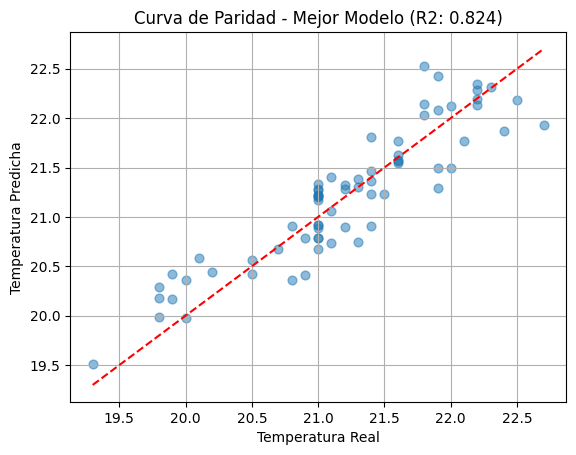

In [8]:
# Usar el mejor modelo polinómico (puedes cambiar por Ridge/Lasso si el R2 es mejor)
y_val_pred_inv = scaler_y.inverse_transform(best_pred.reshape(-1, 1))
y_val_inv = scaler_y.inverse_transform(y_val)
plt.scatter(y_val_inv, y_val_pred_inv, alpha=0.5, s=40)
plt.plot([y_val_inv.min(), y_val_inv.max()], [y_val_inv.min(), y_val_inv.max()], 'r--')
plt.xlabel('Temperatura Real')
plt.ylabel('Temperatura Predicha')
plt.title(f'Curva de Paridad - Mejor Modelo (R2: {best_r2:.3f})')
plt.grid(True)
plt.show()

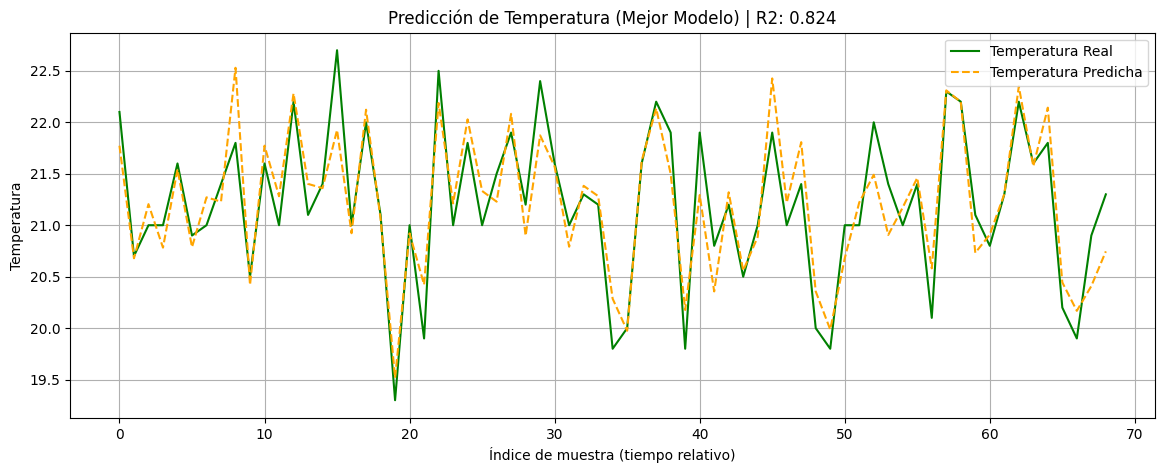

In [9]:
# Serie temporal: Temperatura real vs predicha (validación, desescalada)
plt.figure(figsize=(14,5))
plt.plot(np.arange(len(y_val_inv)), y_val_inv, label='Temperatura Real', color='green')
plt.plot(np.arange(len(y_val_pred_inv)), y_val_pred_inv, label='Temperatura Predicha', color='orange', linestyle='--')
plt.xlabel('Índice de muestra (tiempo relativo)')
plt.ylabel('Temperatura')
plt.title(f'Predicción de Temperatura (Mejor Modelo) | R2: {best_r2:.3f}')
plt.legend()
plt.grid(True)
plt.show()

## Explicación comparativa
Se probaron y compararon diferentes técnicas de regresión lineal, polinómica y regularizada (Ridge, Lasso, ElasticNet). Observa los valores de R² y las gráficas para decidir cuál se ajusta mejor a los datos de temperatura. Esta comparativa masiva permite identificar el modelo más robusto y preciso para el problema.